# TODO: FID is not good

In [1]:
!nvidia-smi

Fri Nov 29 17:05:08 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090 ...    Off | 00000000:01:00.0 Off |                  N/A |
| N/A   43C    P8               2W /  80W |  10521MiB / 16376MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# FID evaluation

In [68]:
from utils import *

from tqdm import tqdm,trange
import torchvision.utils as vutils
from IPython.display import Image, display
import torch
import torch.nn as nn
import torch.nn.functional as F
import os

In [69]:
import numpy as np
from PIL import Image as pil_Image
def gen_for_fid(sample_func,start_idx, folder,batch_size=1024, total_samples=50000):
    os.makedirs(folder, exist_ok=True)
    # sample func: num -> [num, 1, 28, 28]
    num_batchs = total_samples // batch_size + 1
    samples = []
    remains = total_samples
    for i in trange(num_batchs,desc='Generation'):
        samples.append(sample_func(min(remains, batch_size),start_idx).cpu().numpy())
        remains -= batch_size
    # we save each sample into a single image file
    samples = np.concatenate(samples)
    samples = samples[:total_samples]
    samples = samples.transpose(0, 2, 3, 1)
    print('gathered samples with shape:', samples.shape)
    samples = (np.clip(samples,0,1) * 255).astype(np.uint8)
    for i, sample in tqdm(enumerate(samples),desc='Saving images',total=total_samples):
        # print('sample:', sample.shape, sample.min(), sample.max(), sample.dtype)
        pil_Image.fromarray(sample[...,0]).save(f'{folder}/{i}.png')

In [70]:
from cleanfid import fid

In [71]:
if not os.path.exists('./mnist_fid_stats.npz'):
    # get MNIST folder statistics
    feature_extractor = fid.build_feature_extractor(mode='clean', device='cuda', use_dataparallel=True)
    mnist_fid_stats = fid.get_folder_features('./mnist_fid_cache',feature_extractor)
    mu_cache = np.mean(mnist_fid_stats, axis=0)
    sigma_cache = np.cov(mnist_fid_stats, rowvar=False)
    np.savez('mnist_fid_stats.npz', {'mu': mu_cache, 'sigma': sigma_cache})
else:
    mnist_fid_stats = np.load('mnist_fid_stats.npz',allow_pickle=True)
    # print(mnist_fid_stats['arr_0'])
    arr = mnist_fid_stats['arr_0']
    l = arr.tolist()
    mu_cache = l['mu']
    sigma_cache = l['sigma']
    assert mu_cache.shape == (2048,) and sigma_cache.shape == (2048, 2048)

In [72]:
def eval_fid(folder):
    feature_extractor = fid.build_feature_extractor(mode='clean', device='cuda', use_dataparallel=True)
    folder_stats = fid.get_folder_features(folder,feature_extractor)
    folder_mu = np.mean(folder_stats, axis=0)
    folder_sigma = np.cov(folder_stats, rowvar=False)
    fid_score = fid.frechet_distance(folder_mu, folder_sigma, mu_cache, sigma_cache)
    print(folder,' has fid:', fid_score)
    del feature_extractor
    torch.cuda.empty_cache()
    return fid_score

## Dataloader sanity

In [ ]:
eval_fid('fid_samples/sanity')

Found 5000 images in the folder fid_samples/sanity


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.54it/s]


fid_samples/sanity  has fid: 19.598593258845682


np.float64(19.598593258845682)

In [ ]:
# noise vae generation
def sanity_dataloader(num,start_idx=0):
    out = []
    for i in range(start_idx,start_idx+num):
        out.append(test_dataset[i][0].unsqueeze(0))
    x = torch.cat(out)
    return x

gen_for_fid(sanity_dataloader, 'fid_samples/sanity', total_samples=5000,batch_size=512)

Generation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 52.85it/s]


gathered samples with shape: (5000, 28, 28, 1)


Saving images: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 14779.17it/s]


### Baseline 1: VAE

In [7]:
assert False

AssertionError: 

In [73]:
from vae import VAE
vae_model = VAE().cuda()
print('number of parameters:', sum(p.numel() for p in vae_model.parameters()))
vae_model.load_state_dict(torch.load('checkpoints/ep50_vae.pth'))

number of parameters: 944600


/tmp/ipykernel_23520/2768480163.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae_model.load_state_dict(torch.load('checkpoints/ep50_vae.pth'))


<All keys matched successfully>

In [75]:
print('number of parameters:', sum(p.numel() for p in vae_model.dec.parameters()))

number of parameters: 472624


In [59]:
class VAE_Sampler(SamplerBase):

    def calc(self,model,num):
        return model.decode(torch.randn(num, model.latent_dim).cuda())
    
    @torch.no_grad()
    def sample(self, model, num, desc):
        x_data = next(iter(test_loader))[0][:num].cuda()
        
        # generation
        x = self.calc(model, num)
        grid = vutils.make_grid(x, nrow=8)
        vutils.save_image(grid, f'samples/{desc}_gen.png')
        
        # reconstruction
        
        mu, logvar = model.encode(x_data)
        x_recon = model.decode(mu+torch.randn_like(mu)*torch.exp(logvar/2))
        grid = vutils.make_grid(x_recon, nrow=8)
        vutils.save_image(grid, f'samples/{desc}_recon.png')
        grid = vutils.make_grid(x_data, nrow=8)
        vutils.save_image(grid, f'samples/{desc}_data.png')
        
        torch.save(model.state_dict(), f'checkpoints/{desc}.pth')
        

In [60]:
# noise vae generation
sampler = VAE_Sampler()

def vae_sample(num,start_idx=0):
    with torch.no_grad():
        x = sampler.calc(vae_model, num)
    return x

gen_for_fid(vae_sample, 'fid_samples/vae', total_samples=5000)

Generation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 683.54it/s]


gathered samples with shape: (8000, 28, 28, 1)


Saving images: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:00<00:00, 9365.80it/s]


In [61]:
eval_fid('fid_samples/vae')

Found 8000 images in the folder fid_samples/vae


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:14<00:00,  4.32it/s]


fid_samples/vae  has fid: 135.28814403112773


np.float64(135.28814403112773)

In [30]:
torch.cuda.empty_cache()

### Baseline 2: Full DDPM

In [ ]:
assert False

In [8]:
# cosine schedule
from math import pi
T = 1000
angles = torch.linspace(0.1, pi-0.1, T)
alpha_bars = (1 + torch.cos(angles)) / 2
alphas = torch.ones_like(alpha_bars,dtype=torch.float)
alphas[1:] = alpha_bars[1:] / alpha_bars[:-1]
sigmas = torch.sqrt(1-alphas)
alpha_bars[::100]

tensor([0.9975, 0.9616, 0.8860, 0.7771, 0.6444, 0.4993, 0.3542, 0.2217, 0.1131,
        0.0378])

In [9]:
from vanilla_unet import UNet
model = UNet().cuda()
model = nn.DataParallel(model)
print('model params:', sum(p.numel() for p in model.parameters()))
model.load_state_dict(torch.load('checkpoints/ep_50_full_ddpm.pth'))

model params: 6065665


/tmp/ipykernel_23520/3316120823.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoints/ep_50_full_ddpm.pth'))


<All keys matched successfully>

In [10]:
class DDPM_Sampler_test(SamplerBase):
    def __init__(self,max_T=500):
        self.max_T = max_T
        
    def calc(self,model,x0,num):
        x = x0
        
        for t in trange(self.max_T-1,-1,-1):
            w1 = 1/torch.sqrt(alphas[t]).cuda()
            w2 = (1-alphas[t])/torch.sqrt(1-alpha_bars[t]).cuda()
            x = w1 * (x - w2 * model(x,torch.tensor([t]).cuda().repeat(x.shape[0],))) + sigmas[t].cuda().reshape(-1,1,1,1) * torch.randn_like(x)
        
        return x

    @torch.no_grad()
    def sample(self, model, x0, num, desc):
        x = self.calc(model, x0,num)
        grid = vutils.make_grid(x, nrow=8)
        vutils.save_image(grid, f'samples/{desc}.png')

In [ ]:
sampler = DDPM_Sampler_test(max_T=T)
# noise vae generation
def full_ddpm_sample(num,start_idx=0):
    with torch.no_grad():
        x = sampler.calc(model, torch.randn(num,1,28,28).cuda(),num).cpu()
    return x

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 50.51it/s]


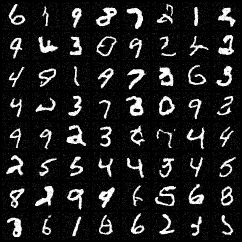

In [33]:
images = full_ddpm_sample(64)
grid = vutils.make_grid(images, nrow=8)
vutils.save_image(grid, 'samples/fid_test_full_ddpm.png')
display(Image('samples/fid_test_full_ddpm.png'))

In [ ]:
gen_for_fid(full_ddpm_sample, 'fid_samples/full_ddpm', total_samples=5000,batch_size=512)

In [18]:
eval_fid('fid_samples/full_ddpm')

Found 5000 images in the folder fid_samples/full_ddpm


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.72it/s]


fid_samples/full_ddpm  has fid: 139.0105312203112


np.float64(139.0105312203112)

## Half DDPM + dataloader

In [49]:
model = UNet().cuda()
model = nn.DataParallel(model)
model.load_state_dict(torch.load('checkpoints/ep_50_half_ddpm.pth'))

/tmp/ipykernel_23520/2752930410.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoints/ep_50_half_ddpm.pth'))


<All keys matched successfully>

In [54]:
sampler = DDPM_Sampler_test(max_T=500)
# noise vae generation
def half_ddpm_sample(num,start_idx=0):
    out = []
    for i in range(start_idx,start_idx+num):
        out.append(test_dataset[i][0].unsqueeze(0))
    x = torch.cat(out)
    noise = torch.randn_like(x)
    x = (noise + x)/torch.sqrt(torch.tensor(2.))
    with torch.no_grad():
        x = sampler.calc(model, x.cuda(),num).cpu()
    return x

  0%|                                                                                                                                                                               | 0/500 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:10<00:00, 49.97it/s]


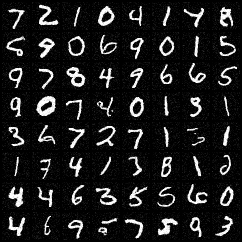

In [55]:
x = half_ddpm_sample(64)
grid = vutils.make_grid(x, nrow=8)
vutils.save_image(grid, 'samples/fid_test_half_ddpm.png')
display(Image('samples/fid_test_half_ddpm.png'))

In [56]:
gen_for_fid(half_ddpm_sample, 'fid_samples/half_ddpm_data', total_samples=5000,batch_size=512)


Generation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [16:10<00:00, 97.02s/it]


gathered samples with shape: (5000, 28, 28, 1)


Saving images: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 7778.76it/s]


In [57]:
eval_fid('fid_samples/half_ddpm_data')

Found 5000 images in the folder fid_samples/half_ddpm_data


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.68it/s]


fid_samples/half_ddpm_data  has fid: 137.1436488667596


np.float64(137.1436488667596)